# Strategy selection 

### PLAN FOR INFERTRADE

This notebook is research on the strategy selection and my aim here is to pass the same ranked dataframe "strategy_df" to the user so they can validate the strategies performance and use the best one for their trading.

Plan for building the function for infertrade package:

    1) Step 1: Let the use pass all the strategy returns
    2) Step 2: Our function wILL take those returns and uses the feature importance from the below to calculate score
    3) Step 3: Rank the strategies
    4) Step 4: Output as dataframe with user argument like: csv=False/True
    
***If you are not able to view the shap plots please use the HTML version of this notebook to view***

In [1]:
# Importing libraries

import pandas as pd 
import numpy as np 
import yfinance as yf 
import empyrical as ep 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 

In [2]:
# Imporing data

# Importing Down trend data AUDUSD data 
# Importing Up trend data SPY
# We are using both down trend and up trend data to analyse the performance metrics. Up trend data gives us the cumulative return > 0,
# while down trend data has cumulative return return < 0 thus we can train binary classification.
# cumulative return > 0 as label 1 and cumulative return < 0 as label -1, therefore we are using both up & down trend data.

df1 = yf.download(tickers="AUDUSD=X", start="2010-01-01", end="2020-01-01")
df2 = yf.download(tickers="SPY", start="2010-01-01", end="2020-01-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# First data AUDUSD is a forex data, so we will remove the Adjusted close and volume data keeping only OHLC

df1 = df1.rename(columns={"Close":"close", "Open":"open", "High":"high", "Low":"low"})
del df1["Adj Close"]
del df1["Volume"]
df1

,open,high,low,close
Date,,,,
2009-12-31,0.894614,0.901063,0.893176,0.898311
2010-01-01,0.898311,0.898473,0.897827,0.898473
2010-01-04,0.897424,0.913910,0.894214,0.912492
2010-01-05,0.912825,0.917347,0.909504,0.911826
2010-01-06,0.911826,0.921914,0.910415,0.920471
...,...,...,...,...
2019-12-25,0.692281,0.692713,0.691611,0.692185
2019-12-26,0.692800,0.694203,0.692185,0.692473
2019-12-27,0.694800,0.698600,0.694370,0.694637


In [4]:
# Seconda data is a SPY data. Here we will use close as adjusted close and we will remove the unadjusted close data and volume, keeping only OHLC

del df2["Close"]
df2 = df2.rename(columns={"Adj Close":"close", "Open":"open", "High":"high", "Low":"low"})
del df2["Volume"]
df2

,open,high,low,close
Date,,,,
2009-12-31,112.769997,112.800003,111.389999,88.700676
2010-01-04,112.370003,113.389999,111.510002,90.205009
2010-01-05,113.260002,113.680000,112.849998,90.443825
2010-01-06,113.519997,113.989998,113.430000,90.507469
2010-01-07,113.500000,114.330002,113.180000,90.889565
...,...,...,...,...
2019-12-23,321.589996,321.649994,321.059998,312.276489
2019-12-24,321.470001,321.519989,320.899994,312.286194
2019-12-26,321.649994,322.950012,321.640015,313.948608


In [5]:
# Creating seperate column for date from index for both data 

df1["date"] = df1.index
df2["date"] = df2.index

### Simulation 

* Our Aim here is to use the 2018 data to generate the 2019 data using brownian simulation
* We will generate 500 simulation 
* Later, we will use these simulated series to get the performance metrics
* Simulation calculated using the below formula:
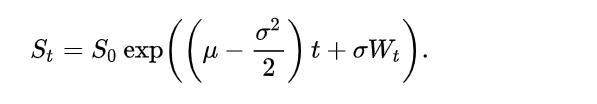

* reference: 
    * https://en.wikipedia.org/wiki/Geometric_Brownian_motion
    * https://blog.quantinsti.com/random-walk/

### Simulation and extracting the features for AUDUSD 

In [6]:
# using 2018 data to simulate the 2019

In [7]:
# Using trading days as 252

df2018_au=df1[df1["date"].dt.year==2018]
df2018_au=df2018_au.iloc[-252:]
df2018_au["return"] = df2018_au["close"].pct_change()

In [8]:
df2018_au.head() 

,open,high,low,close,date,return
Date,,,,,,
2018-01-12,0.788581,0.790320,0.784868,0.788581,2018-01-12,NaN
2018-01-15,0.790889,0.797894,0.790889,0.790889,2018-01-15,0.002926
2018-01-16,0.796052,0.797703,0.793777,0.796292,2018-01-16,0.006832
2018-01-17,0.797257,0.799898,0.794130,0.797130,2018-01-17,0.001052
2018-01-18,0.797162,0.800705,0.794281,0.797251,2018-01-18,0.000151


In [9]:
# parameters for the GBM

mu_au = df2018_au["return"].mean()
sig_au = df2018_au["return"].std()
var_au = df2018_au["return"].var()
tp_au = 1

In [10]:
# simulating the 2019 series based on 2018

In [11]:
def simulate(df, mu, sig, var, tp, n):
    cur_price = df["close"].iloc[-1]  
    drift = (mu-(var/2))*tp
    tot_simulation = n
    all_simulation = pd.DataFrame()
    for sim in range(1, tot_simulation+1):
        _d2019 = []
        for i in range(1,253):
            if i==1:
                _d2019.append(cur_price)
                shock = sig*np.random.normal()
                new_price = cur_price*np.exp(drift+shock)
                _d2019.append(new_price)
            else:
                shock = sig*np.random.normal()
                new_price = _d2019[-1]*np.exp(drift+shock) 
                _d2019.append(new_price)
        all_simulation["Simulation_"+str(sim)] = _d2019
    return (all_simulation)

In [12]:
df_simulation_au = simulate(df2018_au, mu_au, sig_au, var_au, tp_au, 500)

C:\anaconda3\envs\infertradenv\lib\site-packages\ipykernel_launcher.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [13]:
# 500 simulations for AUDUSD

df_simulation_au

,Simulation_1,Simulation_2,Simulation_3,Simulation_4,Simulation_5,Simulation_6,Simulation_7,Simulation_8,Simulation_9,Simulation_10,...,Simulation_491,Simulation_492,Simulation_493,Simulation_494,Simulation_495,Simulation_496,Simulation_497,Simulation_498,Simulation_499,Simulation_500
0,0.704473,0.704473,0.704473,0.704473,0.704473,0.704473,0.704473,0.704473,0.704473,0.704473,...,0.704473,0.704473,0.704473,0.704473,0.704473,0.704473,0.704473,0.704473,0.704473,0.704473
1,0.699998,0.712931,0.699798,0.701127,0.714223,0.701026,0.698152,0.697589,0.702060,0.697191,...,0.706004,0.700496,0.708695,0.705802,0.701515,0.703222,0.704111,0.706042,0.701791,0.703791
2,0.698975,0.715929,0.701822,0.703258,0.715542,0.701904,0.697888,0.699370,0.709690,0.696299,...,0.711060,0.703251,0.706382,0.705752,0.703920,0.698852,0.697457,0.704345,0.703026,0.699304
3,0.702211,0.718536,0.699344,0.701505,0.714226,0.701978,0.699090,0.704129,0.703007,0.692160,...,0.706162,0.699501,0.704539,0.706163,0.706257,0.700875,0.692105,0.705592,0.702216,0.697423
4,0.701229,0.713296,0.694571,0.699693,0.714358,0.697573,0.695822,0.702226,0.699983,0.690386,...,0.711678,0.703704,0.701807,0.712593,0.705348,0.695902,0.693050,0.709798,0.703483,0.693241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.564847,0.535174,0.673565,0.628565,0.633044,0.584853,0.676711,0.639708,0.764561,0.686701,...,0.541353,0.687789,0.581404,0.665880,0.601878,0.565816,0.613642,0.631999,0.635513,0.537368
249,0.565471,0.536038,0.663824,0.626935,0.626239,0.583982,0.679398,0.641470,0.764221,0.689687,...,0.537555,0.686014,0.582329,0.666646,0.593487,0.565253,0.617199,0.632639,0.634510,0.535948
250,0.560236,0.536305,0.667020,0.628452,0.623108,0.584954,0.675235,0.636716,0.760776,0.687472,...,0.540210,0.689870,0.578882,0.667259,0.594226,0.563293,0.617392,0.630455,0.635640,0.535876
251,0.560323,0.536366,0.667435,0.625249,0.617694,0.589493,0.677001,0.634213,0.761569,0.685755,...,0.543100,0.687387,0.577046,0.669016,0.595872,0.560385,0.619109,0.633773,0.634514,0.531270


C:\anaconda3\envs\infertradenv\lib\site-packages\ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


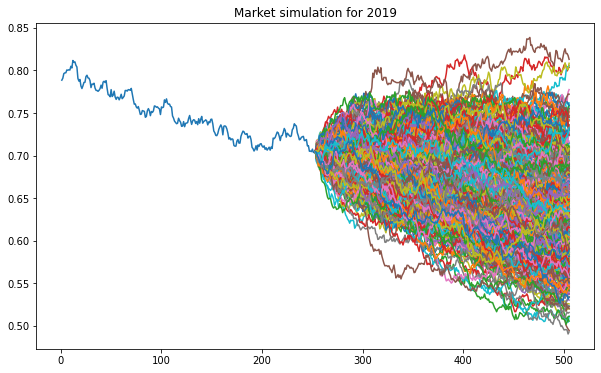

In [14]:
# simulation visualization

df_simulation_au.index = [x for x in range(253, 2*253)]
df_simulation_au["days"] = df_simulation_au.index
plt.figure(figsize=(10,6))
plt.plot([x for x in range(1, 253)], df2018_au["close"].values)
for i in range(len(df_simulation_au.columns[:-1])):
    plt.plot(df_simulation_au.index, df_simulation_au.iloc[:, i])
plt.title("Market simulation for 2019")
plt.show() 

In [15]:
# Actual 2019 values
df2019_au = df1[df1["date"].dt.year==2019]
df2019_au.head() 

,open,high,low,close,date
Date,,,,,
2019-01-01,0.704176,0.711035,0.701508,0.704176,2019-01-01
2019-01-02,0.704722,0.704821,0.698470,0.704791,2019-01-02
2019-01-03,0.692008,0.701951,0.691946,0.691898,2019-01-03
2019-01-04,0.700722,0.711238,0.699496,0.700624,2019-01-04
2019-01-07,0.712606,0.714388,0.711551,0.712378,2019-01-07


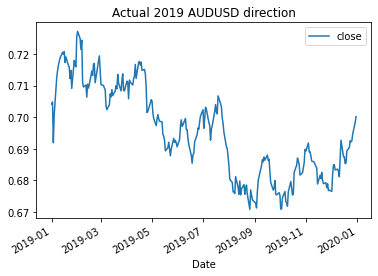

In [16]:
df2019_au["close"].plot(label="close") 
plt.title("Actual 2019 AUDUSD direction")
plt.legend() 
plt.show()

In [17]:
df_simulation_au = df_simulation_au.reset_index(drop=True)

In [18]:
# Here we will use the above simulated price series for generating the features
# we will loop each simulation data to get the performance metrics
# To calculate the metrics we are using Quantopians empyrical library

In [19]:
def getfeatures(returns, datatp, starting_value=1.0):
    perfs = {}
    perfs["Cumulative return"] = ep.cum_returns_final(returns=returns, starting_value=starting_value)
    perfs["Maximum drawdown"] = ep.max_drawdown(returns=returns)
    perfs["Annual volatility"] = ep.annual_volatility(returns=returns, period=datatp) 
    perfs["Calmar ratio"] = ep.calmar_ratio(returns=returns, period=datatp)
    perfs["Omega ratio"] = ep.omega_ratio(returns=returns)
    perfs["Sharpe ratio"] = ep.sharpe_ratio(returns=returns, period=datatp)
    perfs["Sortino ratio"] = ep.sortino_ratio(returns=returns, period=datatp)
    perfs["Downside risk"] = ep.downside_risk(returns=returns, period=datatp)
    perfs["Stability"] = ep.stability_of_timeseries(returns=returns)
    perfs["Tail ratio"] = ep.tail_ratio(returns=returns)
    perfs["VaR"] = ep.value_at_risk(returns=returns.dropna())
    perfs["Annual return"] = ep.annual_return(returns=returns, period=datatp)
    return (perfs)

In [20]:
def simulatedfeatures(simdf, datatp, starting_value=1.0):
    allrows = []
    cols = simdf.columns
    for c in cols:
        returns = simdf[c].pct_change()
        dict_features = getfeatures(returns=returns, datatp=datatp, starting_value=starting_value)
        rowsfeat = np.array([x for x in dict_features.values()])
        allrows.append(rowsfeat)
    colsfeat = [x for x in dict_features.keys()]
    fetaures = pd.DataFrame(data=allrows, columns=colsfeat)
    return(fetaures)

In [21]:
# We are using daily data and returns are starting with 1.0

df_sim_au=simulatedfeatures(df_simulation_au, "daily", 1.0)

C:\anaconda3\envs\infertradenv\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


In [22]:
df_sim_au

,Cumulative return,Maximum drawdown,Annual volatility,Calmar ratio,Omega ratio,Sharpe ratio,Sortino ratio,Downside risk,Stability,Tail ratio,VaR,Annual return
0,0.908767,-0.160312,0.090368,-0.566950,0.853927,-1.013420,-1.385002,0.066123,0.801459,0.910596,-0.009752,-0.090889
1,0.793396,-0.232680,0.086637,-0.884810,0.658441,-2.626882,-3.274758,0.069497,0.965848,0.855292,-0.009485,-0.205878
2,0.785071,-0.227538,0.092905,-0.941283,0.669386,-2.557038,-3.189507,0.074482,0.777371,0.838489,-0.010383,-0.214178
3,0.895284,-0.121858,0.092729,-0.856116,0.837468,-1.146392,-1.516744,0.070087,0.426022,0.878080,-0.009954,-0.104324
4,0.792729,-0.209783,0.084540,-0.984558,0.647619,-2.704047,-3.272522,0.069855,0.960516,0.790824,-0.009298,-0.206543
...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.973482,-0.094078,0.083169,-0.280773,0.957066,-0.281704,-0.391723,0.059811,0.145089,1.002296,-0.008323,-0.026414
497,0.833158,-0.172791,0.088446,-0.962090,0.724184,-2.018992,-2.685852,0.066486,0.809345,0.971037,-0.009313,-0.166241
498,0.851388,-0.172651,0.081642,-0.857630,0.734978,-1.929329,-2.502298,0.062948,0.398208,0.933023,-0.008355,-0.148071
499,0.766164,-0.238898,0.085114,-0.975434,0.612550,-3.085348,-3.767751,0.069699,0.942341,0.789450,-0.009398,-0.233029


In [23]:
# For each simulation we have performance metrics. We will do the same steps for SPY data

#### Simulation for SPY 

In [24]:
df2018_sy=df2[df2["date"].dt.year==2018]
df2018_sy=df2018_sy.iloc[-252:]
df2018_sy["return"] = df2018_sy["close"].pct_change()

In [25]:
# parameters for the GBM

mu_sy = df2018_sy["return"].mean()
sig_sy = df2018_sy["return"].std()
var_sy = df2018_sy["return"].var()
tp_sy = 1

In [26]:
# simulating the 2019 series based on 2018

In [27]:
df_simulation_sy = simulate(df2018_sy, mu_sy, sig_sy, var_sy, tp_sy, 500)

C:\anaconda3\envs\infertradenv\lib\site-packages\ipykernel_launcher.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [28]:
df_simulation_sy

,Simulation_1,Simulation_2,Simulation_3,Simulation_4,Simulation_5,Simulation_6,Simulation_7,Simulation_8,Simulation_9,Simulation_10,...,Simulation_491,Simulation_492,Simulation_493,Simulation_494,Simulation_495,Simulation_496,Simulation_497,Simulation_498,Simulation_499,Simulation_500
0,238.446442,238.446442,238.446442,238.446442,238.446442,238.446442,238.446442,238.446442,238.446442,238.446442,...,238.446442,238.446442,238.446442,238.446442,238.446442,238.446442,238.446442,238.446442,238.446442,238.446442
1,238.636911,238.509686,239.725936,236.318343,234.695109,237.231111,236.522261,240.575339,237.272239,237.153562,...,240.203131,238.037250,235.501797,238.477271,242.056724,236.792408,236.823103,239.913118,235.624763,236.782261
2,234.429867,233.884626,243.342401,237.982376,232.952414,235.718735,235.151917,241.846034,243.089014,241.058833,...,235.732542,236.490883,235.600773,237.789885,242.057799,240.304381,237.877183,238.862506,233.951451,235.722890
3,236.855434,231.367503,240.127347,236.893241,234.052940,230.028981,234.354192,240.103430,241.943007,244.878865,...,235.365120,237.179040,233.387037,238.235633,240.291529,244.029648,239.578911,235.130141,238.486561,238.352774
4,238.120199,232.885425,240.926013,235.299440,235.278517,228.279541,232.692297,237.501566,244.341148,243.788090,...,234.537889,235.144228,231.848699,239.274803,241.208135,243.053523,239.351953,233.833209,235.808681,239.128082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,255.329504,239.207065,198.303631,305.299955,346.241995,245.708454,229.693302,184.374220,232.046379,240.539171,...,203.417959,235.670616,214.333166,212.265527,195.927793,306.588432,273.645960,263.261626,222.220874,261.213574
249,253.549035,236.641485,201.452187,302.862309,339.926757,244.102379,231.542989,187.149528,232.179769,242.346653,...,204.221564,236.243756,216.998149,215.286460,194.058043,307.842464,273.481977,264.374223,222.622343,262.238213
250,254.506300,238.840356,201.049847,305.437928,338.105355,243.573324,237.041348,185.347677,228.873445,243.718783,...,206.526182,236.591975,217.824896,213.796121,195.567722,310.313978,275.730932,262.148633,218.543930,261.712625
251,253.189792,243.358253,200.435951,308.830872,345.514245,243.167551,235.637637,183.097981,228.751299,243.057721,...,206.273092,230.158032,216.835459,216.602878,195.869651,308.376017,271.755438,265.008122,214.105466,261.534650


C:\anaconda3\envs\infertradenv\lib\site-packages\ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


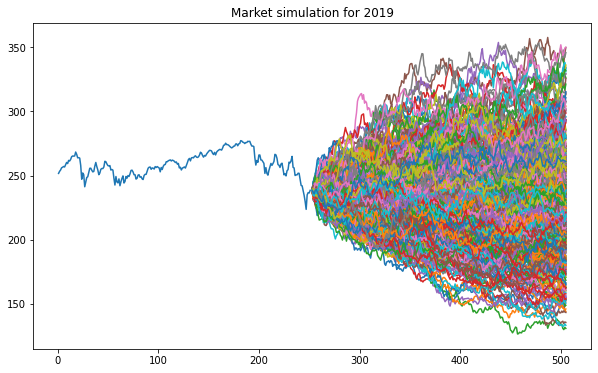

In [29]:
# simulation visualization
df_simulation_sy.index = [x for x in range(253, 2*253)]
df_simulation_sy["days"] = df_simulation_sy.index
plt.figure(figsize=(10,6))
plt.plot([x for x in range(1, 252)], df2018_sy["close"].values)
for i in range(len(df_simulation_sy.columns[:-1])):
    plt.plot(df_simulation_sy.index, df_simulation_sy.iloc[:, i])
plt.title("Market simulation for 2019")
plt.show() 

In [30]:
# Actual 2019 values
df2019_sy = df2[df2["date"].dt.year==2019]
df2019_sy.head() 

,open,high,low,close,date
Date,,,,,
2019-01-02,245.979996,251.210007,245.949997,238.694550,2019-01-02
2019-01-03,248.229996,248.570007,243.669998,232.998611,2019-01-03
2019-01-04,247.589996,253.110001,247.169998,240.803070,2019-01-04
2019-01-07,252.690002,255.949997,251.690002,242.701736,2019-01-07
2019-01-08,256.820007,257.309998,254.000000,244.981979,2019-01-08


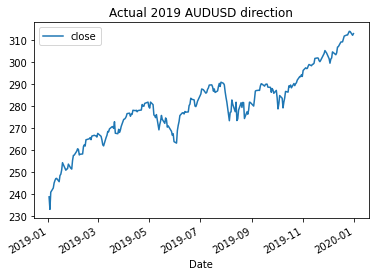

In [31]:
df2019_sy["close"].plot(label="close") 
plt.title("Actual 2019 AUDUSD direction")
plt.legend() 
plt.show()

In [32]:
df_simulation_sy = df_simulation_sy.reset_index(drop=True)

In [33]:
# using simulation to get the features

df_sim_sy=simulatedfeatures(df_simulation_sy, "daily", 1.0)

C:\anaconda3\envs\infertradenv\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


In [34]:
df_sim_sy

,Cumulative return,Maximum drawdown,Annual volatility,Calmar ratio,Omega ratio,Sharpe ratio,Sortino ratio,Downside risk,Stability,Tail ratio,VaR,Annual return
0,1.070401,-0.102569,0.165636,0.683566,1.080988,0.493250,0.721075,0.113303,0.251624,1.112487,-0.015543,0.070113
1,1.006648,-0.218100,0.179610,0.030362,1.020090,0.126262,0.183032,0.123902,0.439803,1.055473,-0.018270,0.006622
2,0.829799,-0.264111,0.164367,-0.642111,0.847624,-1.052695,-1.396507,0.123901,0.546282,0.855199,-0.018280,-0.169589
3,1.292321,-0.084179,0.162634,3.457047,1.299066,1.658447,2.631855,0.102483,0.901203,1.121227,-0.015767,0.291012
4,1.467754,-0.075192,0.174415,6.191202,1.428859,2.288520,3.635205,0.109802,0.727324,1.137789,-0.016166,0.465529
...,...,...,...,...,...,...,...,...,...,...,...,...
496,1.138813,-0.193158,0.155329,0.715620,1.155665,0.914322,1.383071,0.102685,0.614779,1.233377,-0.014630,0.138228
497,1.091656,-0.097955,0.174176,0.931836,1.102802,0.590246,0.859591,0.119600,0.402003,0.956013,-0.019236,0.091278
498,0.921611,-0.128376,0.161524,-0.608308,0.936279,-0.424957,-0.606738,0.113131,0.214734,1.050289,-0.015744,-0.078092
499,1.093482,-0.088888,0.171378,1.047336,1.101782,0.606965,0.868226,0.119808,0.581033,0.986680,-0.017555,0.093096


In [35]:
# combining the features generated from AUDUSD and SPY 

df_comb = pd.concat((df_sim_au, df_sim_sy), axis=0).reset_index(drop=True)

In [36]:
df_comb = df_comb.dropna()
df_comb

,Cumulative return,Maximum drawdown,Annual volatility,Calmar ratio,Omega ratio,Sharpe ratio,Sortino ratio,Downside risk,Stability,Tail ratio,VaR,Annual return
0,0.908767,-0.160312,0.090368,-0.566950,0.853927,-1.013420,-1.385002,0.066123,0.801459,0.910596,-0.009752,-0.090889
1,0.793396,-0.232680,0.086637,-0.884810,0.658441,-2.626882,-3.274758,0.069497,0.965848,0.855292,-0.009485,-0.205878
2,0.785071,-0.227538,0.092905,-0.941283,0.669386,-2.557038,-3.189507,0.074482,0.777371,0.838489,-0.010383,-0.214178
3,0.895284,-0.121858,0.092729,-0.856116,0.837468,-1.146392,-1.516744,0.070087,0.426022,0.878080,-0.009954,-0.104324
4,0.792729,-0.209783,0.084540,-0.984558,0.647619,-2.704047,-3.272522,0.069855,0.960516,0.790824,-0.009298,-0.206543
...,...,...,...,...,...,...,...,...,...,...,...,...
996,1.264583,-0.081918,0.159803,3.215536,1.275637,1.549322,2.253723,0.109856,0.728111,0.928262,-0.017172,0.263410
997,1.138813,-0.193158,0.155329,0.715620,1.155665,0.914322,1.383071,0.102685,0.614779,1.233377,-0.014630,0.138228
998,1.091656,-0.097955,0.174176,0.931836,1.102802,0.590246,0.859591,0.119600,0.402003,0.956013,-0.019236,0.091278
999,0.921611,-0.128376,0.161524,-0.608308,0.936279,-0.424957,-0.606738,0.113131,0.214734,1.050289,-0.015744,-0.078092


In [37]:
# Outcome of the strategy
# If cumulative return > 0 --> good(0) else bad(1)

df_comb["Outcome"] = np.where(df_comb["Cumulative return"]>1.0, 0, 1)

In [38]:
df_comb 

,Cumulative return,Maximum drawdown,Annual volatility,Calmar ratio,Omega ratio,Sharpe ratio,Sortino ratio,Downside risk,Stability,Tail ratio,VaR,Annual return,Outcome
0,0.908767,-0.160312,0.090368,-0.566950,0.853927,-1.013420,-1.385002,0.066123,0.801459,0.910596,-0.009752,-0.090889,1
1,0.793396,-0.232680,0.086637,-0.884810,0.658441,-2.626882,-3.274758,0.069497,0.965848,0.855292,-0.009485,-0.205878,1
2,0.785071,-0.227538,0.092905,-0.941283,0.669386,-2.557038,-3.189507,0.074482,0.777371,0.838489,-0.010383,-0.214178,1
3,0.895284,-0.121858,0.092729,-0.856116,0.837468,-1.146392,-1.516744,0.070087,0.426022,0.878080,-0.009954,-0.104324,1
4,0.792729,-0.209783,0.084540,-0.984558,0.647619,-2.704047,-3.272522,0.069855,0.960516,0.790824,-0.009298,-0.206543,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,1.264583,-0.081918,0.159803,3.215536,1.275637,1.549322,2.253723,0.109856,0.728111,0.928262,-0.017172,0.263410,0
997,1.138813,-0.193158,0.155329,0.715620,1.155665,0.914322,1.383071,0.102685,0.614779,1.233377,-0.014630,0.138228,0
998,1.091656,-0.097955,0.174176,0.931836,1.102802,0.590246,0.859591,0.119600,0.402003,0.956013,-0.019236,0.091278,0
999,0.921611,-0.128376,0.161524,-0.608308,0.936279,-0.424957,-0.606738,0.113131,0.214734,1.050289,-0.015744,-0.078092,1


In [39]:
# Label
# The labels are imbalanced 
# However we will use imbalanced labels for baseline model and to improve the model we can use Synthetic data

df_comb["Outcome"].value_counts()    

1    769
0    231
Name: Outcome, dtype: int64

In [40]:
# For X values we will use the values from max dradwon to Var
# We will not consider annual return because it has tendency to leak the information of cumulative return

X = df_comb.iloc[:, 1:-2]
Y = df_comb.iloc[:, -1]

In [41]:
X.head() 

,Maximum drawdown,Annual volatility,Calmar ratio,Omega ratio,Sharpe ratio,Sortino ratio,Downside risk,Stability,Tail ratio,VaR
0,-0.160312,0.090368,-0.566950,0.853927,-1.013420,-1.385002,0.066123,0.801459,0.910596,-0.009752
1,-0.232680,0.086637,-0.884810,0.658441,-2.626882,-3.274758,0.069497,0.965848,0.855292,-0.009485
2,-0.227538,0.092905,-0.941283,0.669386,-2.557038,-3.189507,0.074482,0.777371,0.838489,-0.010383
3,-0.121858,0.092729,-0.856116,0.837468,-1.146392,-1.516744,0.070087,0.426022,0.878080,-0.009954
4,-0.209783,0.084540,-0.984558,0.647619,-2.704047,-3.272522,0.069855,0.960516,0.790824,-0.009298


In [42]:
# splitting the data
# In the baseline model we will consider train and test data, however to improve the model we will later use
# train, validation and test data

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, shuffle=True, test_size=0.2, random_state=56)

In [43]:
# We will use the simple random forest classifier model to train the data

clf = RandomForestClassifier().fit(xtrain, ytrain)
pred = clf.predict(xtest)

In [44]:
# Accuracy of the model

accuracy_score(ytest, pred)

1.0

In [46]:
# model has high accuracy of predicting the outcome, however our aim is to get the feature importance

In [47]:
# Feature importance from the random forest

In [48]:
df_imp=pd.DataFrame(index=X.columns, data=clf.feature_importances_, columns=["Importances"])
df_imp = df_imp.sort_values(by="Importances", ascending=False)

In [50]:
# Overall feature importance (considering both labels)
df_imp 

,Importances
Sortino ratio,0.276836
Sharpe ratio,0.258566
Omega ratio,0.210855
Calmar ratio,0.173232
Tail ratio,0.041483
Maximum drawdown,0.017317
Annual volatility,0.014167
Downside risk,0.004238
VaR,0.002064
Stability,0.001242


### Model explaination

In [51]:
# we will use the SHAP to explain the model

import shap
shap.initjs() 

In [52]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(xtrain)

In [53]:
# we will explain the model as per label 1 that is when the cumulative return > 0

In [57]:
# The first data here is
xtrain.iloc[0, :]

Maximum drawdown    -0.122207
Annual volatility    0.167425
Calmar ratio         0.801383
Omega ratio          1.110684
Sharpe ratio         0.643860
Sortino ratio        0.914204
Downside risk        0.117915
Stability            0.400471
Tail ratio           0.988622
VaR                 -0.016734
Name: 753, dtype: float64

In [58]:
# actual y value
ytrain.iloc[0]

0

In [59]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], xtrain.iloc[0,:])

According to the shap force plot the performance metrics data has a tendency to get the cumulative return > 0 because the 
fetaure like calmar, sortino, sharpe has potential to increase the  cumulative return however the tail ratio is the only feature that would affect the returns to be < 0.

which is true in theory that as the tail ratio increases the risk of loosing also increases.

In [60]:
# next data here is
i = 2
print("X data", xtrain.iloc[i, :])
print("Y: ", ytrain.iloc[i])
shap.force_plot(explainer.expected_value[0], shap_values[0][i], xtrain.iloc[i,:])

X data Maximum drawdown    -0.094913
Annual volatility    0.085745
Calmar ratio        -0.586388
Omega ratio          0.908226
Sharpe ratio        -0.627705
Sortino ratio       -0.856180
Downside risk        0.062864
Stability            0.194869
Tail ratio           0.906363
VaR                 -0.008846
Name: 493, dtype: float64
Y:  1


According to the above data we can see that performance metrics are not good and it has negative sharpe. Therefore these feature is leading to  cumulative return < 0.

### Feature importance

According to the model,
These feature has similar role:

Sharpe, Calmar, Omega, Sortino that is as the ratio increases the it leads to positive return

However, features like tail ratio, maximum drawdown, down side risk, annual volatility can lead to negative  return if the 
values are increasing.

Therefore our feature importance is based on increasing the cumulative return:

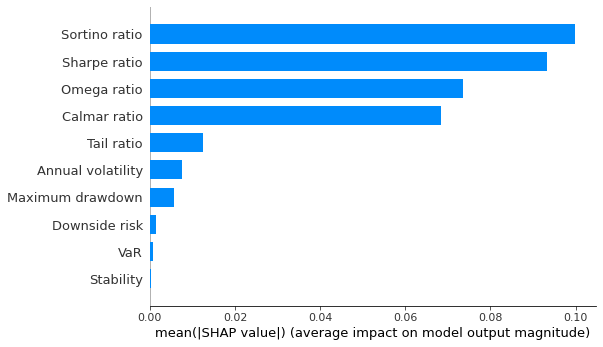

In [61]:
shap.summary_plot(shap_values[0], xtrain, plot_type="bar")

In [62]:
def featurescore(shapevalues,x):
    cols = x.columns
    shap_df = pd.DataFrame(data=shapevalues[0], columns=cols)
    df_imp_ft = pd.DataFrame(index=cols, columns=["Score"])
    for col in cols:
        df_imp_ft["Score"].loc[col] = np.mean(np.abs(shap_df[col]))
    return(df_imp_ft)

In [63]:
feat_score = featurescore(shap_values, xtrain).sort_values(by="Score", ascending=False)
feat_score

,Score
Sortino ratio,0.09986
Sharpe ratio,0.093321
Omega ratio,0.073449
Calmar ratio,0.068487
Tail ratio,0.012384
Annual volatility,0.007521
Maximum drawdown,0.005755
Downside risk,0.001414
VaR,0.000766
Stability,0.000367


In [64]:
# Feature score are calculated from the shap values and are same as bar plot.

### Strategy ranking

* Consider the simulated returns are some strategy returns.
* Ranking the returns from the feature scores calculated.

In [65]:
# We will use the test data to rank the strategy.

In [66]:
def StrategyRank(x_df, scores):
    x = x_df.copy()
    scores_ix = scores.index
    for si in scores_ix:
        x[si] = x[si]*scores["Score"].loc[si]
    x["Strategy score"] = np.sum(x, axis=1)
    x["Normal_Ix"] = [x for x in range(0, x.shape[0])]
    x = x.sort_values(by="Strategy score", ascending=False)
    return(x)

In [67]:
strategy_df=StrategyRank(xtest, feat_score)

In [69]:
strategy_df

,Maximum drawdown,Annual volatility,Calmar ratio,Omega ratio,Sharpe ratio,Sortino ratio,Downside risk,Stability,Tail ratio,VaR,Strategy score,Normal_Ix
917,-0.000528,0.001362,0.335218,0.102266,0.200340,0.340325,0.000161,0.000313,0.014298,-0.000013,0.993743,83
739,-0.000492,0.001276,0.316251,0.101517,0.191826,0.323228,0.000152,0.000343,0.015166,-0.000012,0.949255,113
868,-0.000555,0.001346,0.289648,0.100434,0.187682,0.307405,0.000165,0.000246,0.013401,-0.000013,0.899758,119
525,-0.000481,0.001299,0.259442,0.095901,0.157354,0.276852,0.000149,0.000324,0.017173,-0.000011,0.808003,80
813,-0.000621,0.001288,0.159748,0.091812,0.130839,0.218363,0.000155,0.000314,0.014702,-0.000012,0.616587,68
...,...,...,...,...,...,...,...,...,...,...,...,...
33,-0.001505,0.000713,-0.063385,0.046367,-0.269424,-0.346928,0.000111,0.000341,0.008939,-0.000009,-0.624779,191
363,-0.001329,0.000650,-0.067288,0.046016,-0.274610,-0.361928,0.000099,0.000329,0.010109,-0.000007,-0.647959,82
499,-0.001375,0.000640,-0.066804,0.044991,-0.287927,-0.376247,0.000099,0.000346,0.009777,-0.000007,-0.676507,49
919,-0.002565,0.001271,-0.067726,0.042806,-0.313875,-0.407124,0.000197,0.000352,0.008832,-0.000015,-0.737847,35


In [71]:
# Normal ix column is the index value before sorting the data according to the score and we need the index to trace the shap force  plot

### Model explanation on test data

In [72]:
shap_values_test = explainer.shap_values(xtest)

In [76]:
# shap data takes normal ix
# shap force plot for best return
shap.force_plot(explainer.expected_value[0], shap_values_test[0][83], xtest.loc[917,:])

This strategy return has the highest ranking and we can observe that returns > 1.0 beacuse of good performance metrics value.

In [79]:
# shap force plot for worst return
shap.force_plot(explainer.expected_value[0], shap_values_test[0][71], xtest.loc[413,:])

This strategy return has the lowest ranking and we can observe that returns < 1.0 beacuse of poor performance metrics.

# PLAN FOR INFERTRADE

This notebook is research on the strategy selection and my aim here is to pass the same ranked dataframe "strategy_df" to the user so they can validate the strategies performance and use the best one for their trading.

Plan for building the function for infertrade package:

    1) Step 1: Let the use pass all the strategy returns
    2) Step 2: Our function wILL take those returns and uses the feature importance from the above to calculate score
    3) Step 3: Rank the strategies
    4) Step 4: Output as dataframe with user argument like: csv=False/True